In [9]:
!rm -rf /content/training_set
!unzip /content/training_set.zip
!mkdir /content/training_set/images
!mkdir /content/training_set/annotations
!mv /content/training_set/*_Annotation.png /content/training_set/annotations
!mv /content/training_set/*.png /content/training_set/images

Archive:  /content/training_set.zip
   creating: training_set/
 extracting: training_set/000_HC.png  
  inflating: training_set/000_HC_Annotation.png  
 extracting: training_set/001_HC.png  
  inflating: training_set/001_HC_Annotation.png  
 extracting: training_set/002_HC.png  
  inflating: training_set/002_HC_Annotation.png  
 extracting: training_set/003_HC.png  
  inflating: training_set/003_HC_Annotation.png  
 extracting: training_set/004_HC.png  
  inflating: training_set/004_HC_Annotation.png  
 extracting: training_set/005_HC.png  
  inflating: training_set/005_HC_Annotation.png  
 extracting: training_set/006_HC.png  
  inflating: training_set/006_HC_Annotation.png  
 extracting: training_set/007_HC.png  
  inflating: training_set/007_HC_Annotation.png  
 extracting: training_set/008_HC.png  
  inflating: training_set/008_HC_Annotation.png  
 extracting: training_set/009_HC.png  
  inflating: training_set/009_HC_Annotation.png  
 extracting: training_set/010_2HC.png  
  infla

In [10]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt
import os

In [11]:
class HC18Dataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform_img=None, transform_mask=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = sorted(os.listdir(image_dir))  # Sort to align images and masks
        self.mask_filenames = sorted(os.listdir(mask_dir))
        self.transform_img = transform_img
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])

        # Load images and masks
        image = Image.open(image_path).convert("L")  # Convert to grayscale
        mask = Image.open(mask_path).convert("L")

        # Apply transformations
        if self.transform_img:
            image = self.transform_img(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        return image, mask

# Define transformation of images and mask
image_transformation = transforms.Compose([
    transforms.Grayscale(num_output_channels= 1), # Ensure single channel
    transforms.Resize((256, 256)),
    transforms.ToTensor() # Convert it to tensor
])

mask_transformation = transforms.Compose([
    transforms.Grayscale(num_output_channels= 1),
    transforms.Resize((256, 256)),
    transforms.ToTensor() # Convert it to tensor
])

In [12]:
# Create dataset instance
image_dir = "/content/training_set/images"
mask_dir = "/content/training_set/annotations"
dataset = HC18Dataset(image_dir, mask_dir, image_transformation, mask_transformation)

In [13]:
# ✅ Test dataset
image, mask = dataset[0]
print(f"Image shape: {image.shape}, Mask shape: {mask.shape}")

# ✅ Check value ranges
print(f"Image min-max: {image.min()} to {image.max()}")
print(f"Mask min-max: {mask.min()} to {mask.max()}")

Image shape: torch.Size([1, 256, 256]), Mask shape: torch.Size([1, 256, 256])
Image min-max: 0.0 to 0.9450980424880981
Mask min-max: 0.0 to 0.8509804010391235


In [14]:
from torch.utils.data import DataLoader

# Define batch size
BATCH_SIZE = 8  # You can adjust this based on your GPU/CPU memory

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# Test DataLoader by loading one batch
for batch_images, batch_masks in dataloader:
    print(f"Batch Image Shape: {batch_images.shape}")  # Expected: [BATCH_SIZE, 1, H, W]
    print(f"Batch Mask Shape: {batch_masks.shape}")  # Expected: [BATCH_SIZE, 1, H, W]
    break  # Load only one batch for testing

Batch Image Shape: torch.Size([8, 1, 256, 256])
Batch Mask Shape: torch.Size([8, 1, 256, 256])


In [15]:
import torch
import torch.nn as nn
# import torch.nn.functional as F

class DoubleConv(nn.Module):
    """Two 3x3 Convolution layers followed by BatchNorm and ReLU"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()

        # Encoder (Downsampling Path)
        self.conv1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.conv5 = DoubleConv(512, 1024)

        # Decoder (Upsampling Path)
        self.up6 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv6 = DoubleConv(1024, 512)
        self.up7 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv7 = DoubleConv(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv8 = DoubleConv(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv9 = DoubleConv(128, 64)

        # Output Layer
        self.output = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder path
        x1 = self.conv1(x)
        x2 = self.pool1(x1)
        x2 = self.conv2(x2)
        x3 = self.pool2(x2)
        x3 = self.conv3(x3)
        x4 = self.pool3(x3)
        x4 = self.conv4(x4)
        x5 = self.pool4(x4)

        # Bottleneck
        x5 = self.conv5(x5)

        # Decoder path
        x6 = self.up6(x5)
        x6 = torch.cat([x4, x6], dim=1)  # Skip connection
        x6 = self.conv6(x6)

        x7 = self.up7(x6)
        x7 = torch.cat([x3, x7], dim=1)
        x7 = self.conv7(x7)

        x8 = self.up8(x7)
        x8 = torch.cat([x2, x8], dim=1)
        x8 = self.conv8(x8)

        x9 = self.up9(x8)
        x9 = torch.cat([x1, x9], dim=1)
        x9 = self.conv9(x9)

        output = self.output(x9)  # Final output layer
        return torch.sigmoid(output)  # Sigmoid for binary segmentation

# Create the model
model = UNet(in_channels=1, out_channels=1)
print(f"Model Summary:\n{model}")


Model Summary:
UNet(
  (conv1): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace

In [16]:
import torch.optim as optim

# ✅ Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ✅ Define Loss Function (BCE + Dice Loss)
def dice_loss(pred, target, smooth=1e-5):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return 1 - (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

criterion = lambda pred, target: nn.BCELoss()(pred, target) + dice_loss(pred, target)

# ✅ Define Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ✅ Training Function
def train_model(model, dataloader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# ✅ Train the Model
train_model(model, dataloader, criterion, optimizer, num_epochs=10)

Epoch [1/10], Loss: 1.1554
Epoch [2/10], Loss: 0.9467
Epoch [3/10], Loss: 0.8664
Epoch [4/10], Loss: 0.8460
Epoch [5/10], Loss: 0.8354
Epoch [6/10], Loss: 0.8299
Epoch [7/10], Loss: 0.8267
Epoch [8/10], Loss: 0.8175
Epoch [9/10], Loss: 0.8127
Epoch [10/10], Loss: 0.8074


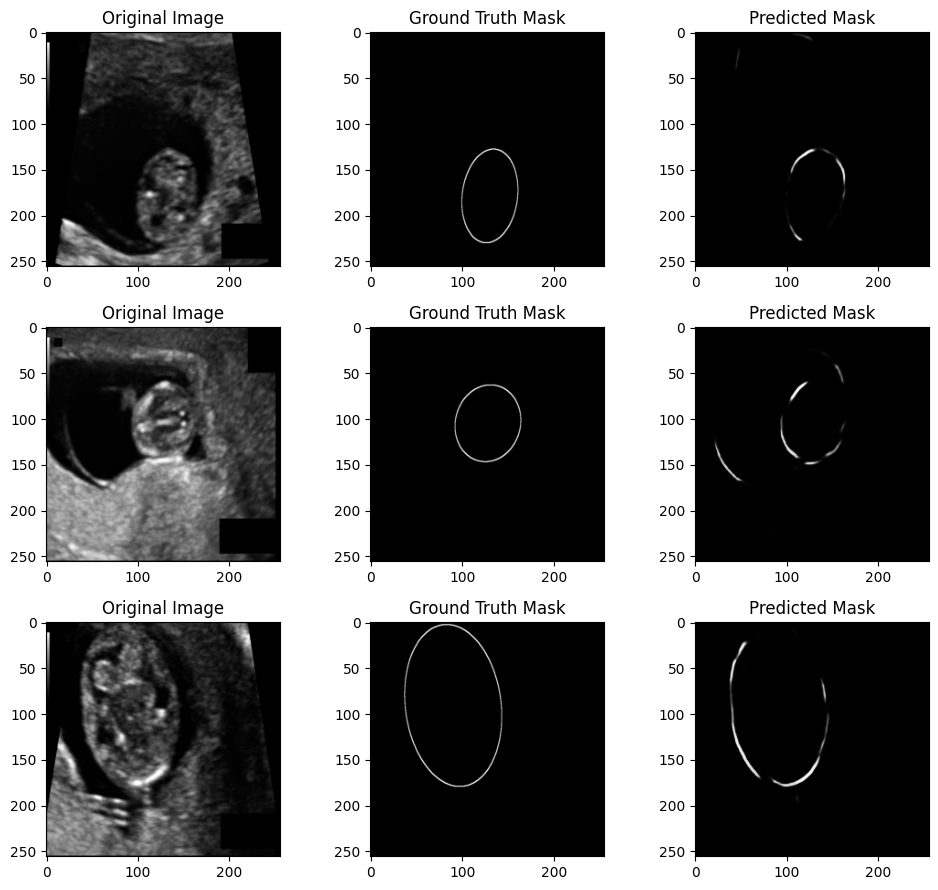

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# ✅ Function to make predictions on a single image
def predict_image(model, image, device):
    model.eval()  # Set to evaluation mode
    with torch.no_grad():
        image = image.to(device).unsqueeze(0)  # Add batch dimension
        output = model(image)
        output = output.squeeze(0).cpu().numpy()  # Remove batch dimension and move to CPU
        return output

# ✅ Visualizing the Results
def visualize_predictions(model, dataset, num_samples=3):
    fig, axs = plt.subplots(num_samples, 3, figsize=(10, num_samples * 3))

    for i in range(num_samples):
        image, mask = dataset[i]  # Get a sample image and mask
        predicted_mask = predict_image(model, image, device)

        axs[i, 0].imshow(image.permute(1, 2, 0), cmap='gray')  # Original Image
        axs[i, 0].set_title("Original Image")

        axs[i, 1].imshow(mask.squeeze(), cmap='gray')  # Ground Truth Mask
        axs[i, 1].set_title("Ground Truth Mask")

        axs[i, 2].imshow(predicted_mask.squeeze(), cmap='gray')  # Predicted Mask
        axs[i, 2].set_title("Predicted Mask")

    plt.tight_layout()
    plt.show()

# ✅ Run the visualization
visualize_predictions(model, dataset)


In [18]:
import torch.nn.functional as F

# ✅ Dice Score Calculation
def dice_coefficient(pred, target, smooth=1e-5):
    pred = (pred > 0.5).float()  # Convert to binary mask (Threshold at 0.5)
    target = target.float()

    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return dice.item()

# ✅ IoU Calculation
def iou_score(pred, target, smooth=1e-5):
    pred = (pred > 0.5).float()
    target = target.float()

    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.item()

# ✅ Evaluate Model on Validation Set
def evaluate_model(model, dataloader, device):
    model.eval()
    dice_scores = []
    iou_scores = []

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            outputs = outputs.squeeze(1).cpu()  # Remove extra dimensions
            masks = masks.squeeze(1).cpu()

            for pred, true in zip(outputs, masks):
                dice_scores.append(dice_coefficient(pred, true))
                iou_scores.append(iou_score(pred, true))

    avg_dice = np.mean(dice_scores)
    avg_iou = np.mean(iou_scores)

    print(f"✅ Average Dice Score: {avg_dice:.4f}")
    print(f"✅ Average IoU Score: {avg_iou:.4f}")

# ✅ Run the Evaluation
evaluate_model(model, dataloader, device)


✅ Average Dice Score: 0.2492
✅ Average IoU Score: 0.1449


In [19]:
import cv2
import numpy as np

# ✅ Function to Calculate Fetal Head Circumference
def calculate_circumference(mask):
    mask = (mask > 0.5).astype(np.uint8)  # Convert to binary (0 and 1)

    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return 0  # No contour found

    # Fit an ellipse around the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    if len(largest_contour) < 5:
        return 0  # Need at least 5 points to fit an ellipse

    ellipse = cv2.fitEllipse(largest_contour)
    (center, axes, angle) = ellipse  # Extract ellipse parameters

    # Circumference approximation: Ramanujan's formula
    a, b = axes[0] / 2, axes[1] / 2  # Semi-major and semi-minor axis
    circumference = np.pi * (3*(a + b) - np.sqrt((3*a + b) * (a + 3*b)))

    return circumference


In [21]:
# ✅ Function to Evaluate Circumference on Validation Data
def evaluate_circumference(model, dataset, num_samples=5):
    model.eval()

    for i in range(num_samples):
        image, _ = dataset[i]
        predicted_mask = predict_image(model, image, device).squeeze()

        # Calculate circumference
        circumference = calculate_circumference(predicted_mask)
        print(f"Sample {i+1}: Estimated Circumference = {circumference:.2f} pixels")

# ✅ Run the evaluation
evaluate_circumference(model, dataset)


Sample 1: Estimated Circumference = 94.07 pixels
Sample 2: Estimated Circumference = 47.29 pixels
Sample 3: Estimated Circumference = 179.02 pixels
Sample 4: Estimated Circumference = 314.07 pixels
Sample 5: Estimated Circumference = 442.62 pixels
